# Étude des *features* par classe (via échantillon) / Scène Pombourg

## Imports

In [38]:
%matplotlib inline

In [39]:
from pathlib import Path

In [40]:
import pandas as pd

In [41]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [42]:
plt.style.use("seaborn-notebook")

In [43]:
from geo3dfeatures.io import las as read_las
from geo3dfeatures.extract import process_eigenvalues, process_full
from geo3dfeatures.extract import compute_tree, request_tree, extract

## Données

In [44]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"

In [45]:
DATADIR = Path("/home/dag/data/geolithe-univers/workspace/input")

In [46]:
LABELS = {"eboulis": 0,
          "falaise": 1,
          "vegetation": 2}

In [47]:
# Labels des coordonnées
COORDS = list("xyz")
# Labels du channel RGB (couleurs)
COULEURS = list("rgb")

In [48]:
rawdata = read_las(DATADIR / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [49]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


## Index spatial

In [14]:
# Taille max des feuilles
LEAF_SIZE = 1_000

In [15]:
tree = compute_tree(rawdata[COORDS].values, leaf_size=LEAF_SIZE)

In [16]:
# on teste la requête d'un point prix au hasard
random_point = rawdata[COORDS].sample()
random_point

,x,y,z
562388,1.977558e+06,5.242288e+06,934.564825


On récupère la distance et les index des K plus proches voisins (ici K=20)

In [17]:
distance, neighbors_index = request_tree(random_point.values, tree, 20)
distance, neighbors_index = distance.squeeze(), neighbors_index.squeeze()
print("distance: ", distance)
print("index: ", neighbors_index)

distance:  [0.         0.07807291 0.08639462 0.09088909 0.11017503 0.1194277
 0.1240607  0.14846534 0.14886122 0.17094592 0.18168694 0.18260857
 0.18425147 0.18493771 0.18550811 0.18696535 0.18848351 0.19050003
 0.19262011 0.19381884 0.19839263]
index:  [562388 563425 561758 563445 561724 563452 561759 563446 561760 563430
 563357 561621 563149 563643 563358 564746 563642 563702 564750 562679
 563435]


In [18]:
# Les 20 points proches (+ 1, celui au centre de la sphère)
rawdata.loc[neighbors_index]

,x,y,z,r,g,b
562388,1.977558e+06,5.242288e+06,934.564825,73.0,86.0,45.0
563425,1.977558e+06,5.242288e+06,934.623602,76.0,91.0,53.0
561758,1.977558e+06,5.242288e+06,934.505988,73.0,85.0,49.0
563445,1.977558e+06,5.242288e+06,934.559149,79.0,93.0,56.0
561724,1.977558e+06,5.242288e+06,934.458014,115.0,127.0,94.0
563452,1.977558e+06,5.242288e+06,934.676276,91.0,105.0,64.0
561759,1.977558e+06,5.242288e+06,934.624411,67.0,78.0,49.0
563446,1.977558e+06,5.242288e+06,934.470282,95.0,110.0,80.0
561760,1.977558e+06,5.242288e+06,934.533667,101.0,110.0,82.0
563430,1.977558e+06,5.242288e+06,934.719244,64.0,81.0,40.0


In [19]:
# Distance (en m)
pd.Series(distance).describe()

count    21.000000
mean      0.149860
std       0.052506
min       0.000000
25%       0.119428
50%       0.181687
75%       0.186965
max       0.198393
dtype: float64

## Features sur les échantillons

On souhaite calculer toutes les *features* sur l'ensemble des échantillons en prenant en considération la totalité de la scène.

On veut aussi calculer ces *features* pour différentes valeurs de "proches voisins".

### Lecture des données

In [50]:
vegetation = pd.DataFrame(read_las(DATADIR / VEGETATION_FILE), columns=COORDS + COULEURS)
falaise = pd.DataFrame(read_las(DATADIR / FALAISE_FILE), columns=COORDS + COULEURS)
eboulis = pd.DataFrame(read_las(DATADIR / EBOULIS_FILE), columns=COORDS + COULEURS)

In [23]:
print("dimension: ", vegetation.shape)
vegetation.head()

dimension:  (16850, 6)


,x,y,z,r,g,b
0,1.977551e+06,5.242293e+06,937.820699,110.0,107.0,83.0
1,1.977551e+06,5.242293e+06,937.845006,102.0,101.0,81.0
2,1.977550e+06,5.242293e+06,937.799840,101.0,99.0,81.0
3,1.977550e+06,5.242294e+06,937.766835,111.0,111.0,93.0
4,1.977550e+06,5.242294e+06,937.785435,117.0,120.0,103.0


In [24]:
print("dimension: ", falaise.shape)
falaise.head()

dimension:  (32440, 6)


,x,y,z,r,g,b
0,1.977542e+06,5.242310e+06,906.728011,187.0,181.0,162.0
1,1.977542e+06,5.242310e+06,906.689833,184.0,180.0,163.0
2,1.977542e+06,5.242310e+06,906.708739,189.0,184.0,168.0
3,1.977542e+06,5.242310e+06,906.659331,179.0,175.0,158.0
4,1.977548e+06,5.242310e+06,913.525405,159.0,148.0,131.0


In [25]:
print("dimension: ", eboulis.shape)
eboulis.head()

dimension:  (24361, 6)


,x,y,z,r,g,b
0,1.977538e+06,5.242330e+06,893.240919,156.0,145.0,140.0
1,1.977537e+06,5.242329e+06,894.037123,163.0,151.0,147.0
2,1.977537e+06,5.242329e+06,893.971159,155.0,143.0,138.0
3,1.977537e+06,5.242329e+06,893.991743,155.0,141.0,135.0
4,1.977537e+06,5.242329e+06,893.926466,143.0,126.0,119.0


### Ordre des grandeurs des distances en fonction du nombre de voisins

Prenons par exemple ce range de nombres de voisons

In [51]:
VOISINS_NUM = [10, 20, 30, 50, 100, 200, 500, 1000, 1500, 2000]

On peut regarder, en moyenne sur un échantillon 20 points par ex., la distance max i.e. le rayon de la sphère pour chaque voisinage.

In [27]:
veg_sample = vegetation[COORDS].sample(20).values
gen = (request_tree(veg_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean": d.mean(axis=1)[0], "max": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM)

,max,mean
10,0.181367,0.123670
20,0.238624,0.166706
30,0.281757,0.196120
50,0.363620,0.249002
100,0.514418,0.347882
200,0.718991,0.483574
500,1.047395,0.735543
1000,1.398045,0.982454
1500,1.667687,1.168923
2000,1.901173,1.322297


In [25]:
falaise_sample = falaise[COORDS].sample(20).values
gen = (request_tree(falaise_sample, tree, num) for num in VOISINS_NUM)
d = [{"mean": d.mean(axis=1)[0], "max": d.max(axis=1)[0]} for d, _ in gen]
pd.DataFrame(d, index=VOISINS_NUM)

,max,mean
10,0.099456,0.069662
20,0.140013,0.095777
30,0.163093,0.114007
50,0.206150,0.141880
100,0.284786,0.193438
200,0.408529,0.268778
500,0.661018,0.434103
1000,0.948186,0.623682
1500,1.159693,0.767728
2000,1.332551,0.887755


Pour les 1000 proches voisins, en max on est pas loin du mètre.

### Études des features par label (hdf5)

On a extrait des features dans autant de voisinage et autant de classe dans des fichiers CSV. Puis rassembler l'ensemble des valeurs dans des fichiers hdf5.

On souhaite comparer des profils de certaines features en fonction de la distance (resp. du nombre de voisins) par type de classe : **falaise**, **eboulis** et **vegetation**

In [52]:
KEYS = {i: "/num_{:04d}".format(i) for i in VOISINS_NUM}
KEYS

{10: '/num_0010',
 20: '/num_0020',
 30: '/num_0030',
 50: '/num_0050',
 100: '/num_0100',
 200: '/num_0200',
 500: '/num_0500',
 1000: '/num_1000',
 1500: '/num_1500',
 2000: '/num_2000'}

In [53]:
vegetation_store = pd.HDFStore("pombourg-vegetation-features.h5", "r")
falaise_store = pd.HDFStore("pombourg-falaise-features.h5", "r")
eboulis_store = pd.HDFStore("pombourg-eboulis-features.h5", "r")

In [54]:
def mean_features(store, feature_name):
    result = pd.Series({num: store[key][feature_name].mean() for num, key in KEYS.items()})
    result.name = feature_name
    return result

In [55]:
mean_features(vegetation_store, "alpha")

10      0.243248
20      0.192339
30      0.182236
50      0.178741
100     0.183587
200     0.195480
500     0.198764
1000    0.203904
1500    0.195272
2000    0.192241
Name: alpha, dtype: float64

#### Distance : radius & radius 2D

In [56]:
radius = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius"),
                       "falaise": mean_features(falaise_store, "radius"),
                       "eboulis": mean_features(eboulis_store, "radius")})

In [57]:
radius

,vegetation,falaise,eboulis
10,0.180025,0.090782,0.085656
20,0.248930,0.123362,0.117428
30,0.303243,0.149129,0.143175
50,0.389988,0.192868,0.183735
100,0.549773,0.272442,0.258036
200,0.774284,0.384385,0.362944
500,1.201101,0.606984,0.569774
1000,1.671263,0.857786,0.801462
1500,2.017296,1.050067,0.978642
2000,2.295291,1.212015,1.127756


Text(0, 0.5, 'rayon moy. (m)')

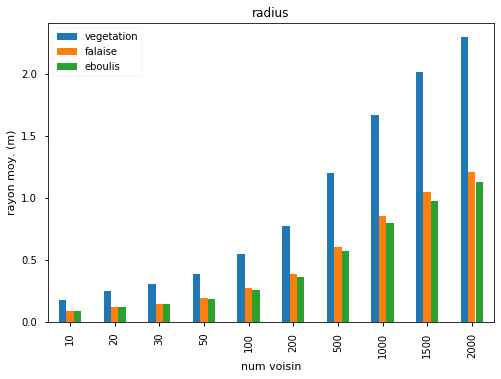

In [58]:
radius.plot(kind="bar", title="radius")
plt.xlabel("num voisin")
plt.ylabel("rayon moy. (m)")

In [59]:
radius_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, "radius_2D"),
                         "falaise": mean_features(falaise_store, "radius_2D"),
                         "eboulis": mean_features(eboulis_store, "radius_2D")})

Text(0, 0.5, 'rayon 2D moy. (m)')

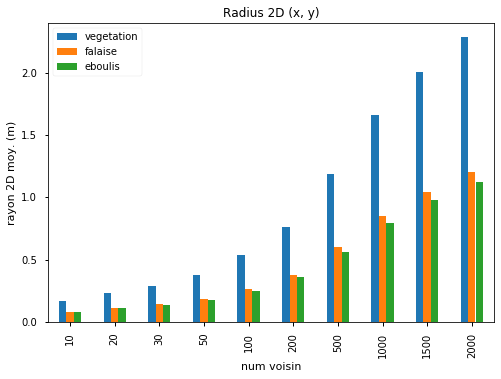

In [60]:
radius_2d.plot(kind="bar", title="Radius 2D (x, y)")
plt.xlabel("num voisin")
plt.ylabel("rayon 2D moy. (m)")

#### Densité - 2D et 3D

In [61]:
key = "density_2D"
density_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'density 2D moy.')

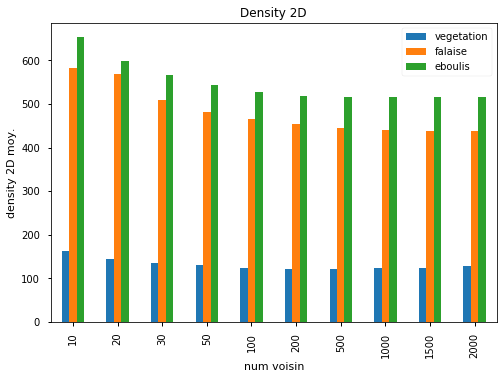

In [62]:
density_2d.plot(kind="bar", title="Density 2D")
plt.xlabel("num voisin")
plt.ylabel("density 2D moy.")

In [63]:
key = "density"
density_3d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'density 3D moy.')

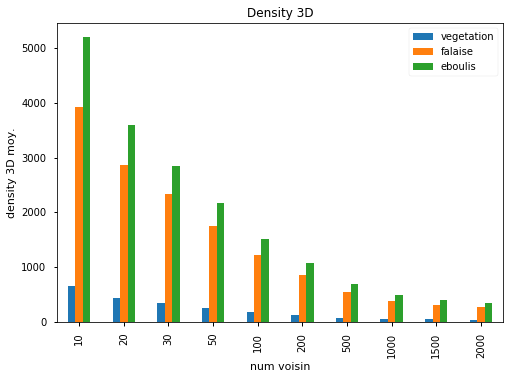

In [64]:
density_3d.plot(kind="bar", title="Density 3D")
plt.xlabel("num voisin")
plt.ylabel("density 3D moy.")

#### Autres features 2D : eigen sum & ratio

In [112]:
key = "eigenvalue_ratio_2D"
eigenratio_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'e2 / e1 moy.')

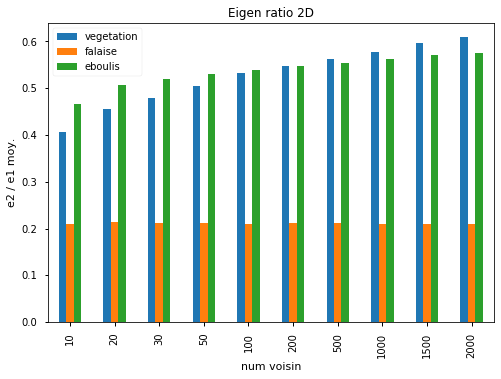

In [114]:
eigenratio_2d.plot(kind="bar", title="Eigen ratio 2D")
plt.xlabel("num voisin")
plt.ylabel("e2 / e1 moy.")

In [115]:
key = "eigenvalue_sum_2D"
eigensum_2d = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'sum_i lambda_i moy.')

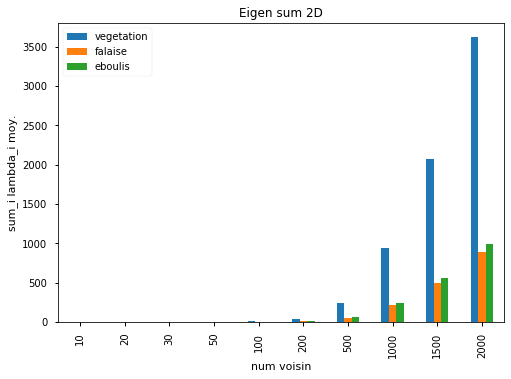

In [116]:
eigensum_2d.plot(kind="bar", title="Eigen sum 2D")
plt.xlabel("num voisin")
plt.ylabel("sum_i lambda_i moy.")

#### alpha & beta

In [65]:
alpha = pd.DataFrame({"vegetation": mean_features(vegetation_store, "alpha"),
                     "falaise": mean_features(falaise_store, "alpha"),
                     "eboulis": mean_features(eboulis_store, "alpha")})

In [66]:
alpha

,vegetation,falaise,eboulis
10,0.243248,0.205583,0.218688
20,0.192339,0.099636,0.133892
30,0.182236,0.082397,0.112161
50,0.178741,0.059802,0.089941
100,0.183587,0.036537,0.073485
200,0.195480,0.026313,0.068262
500,0.198764,0.019796,0.066787
1000,0.203904,0.018956,0.063586
1500,0.195272,0.018735,0.060047
2000,0.192241,0.018968,0.057002


Text(0, 0.5, 'aplha')

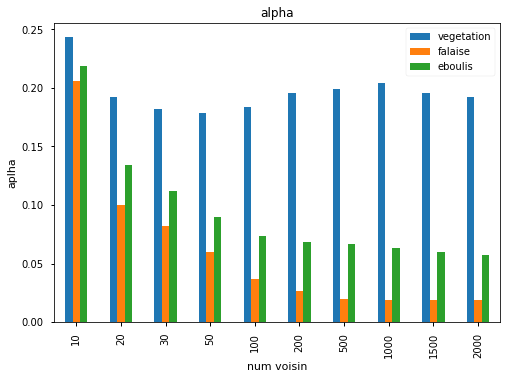

In [67]:
alpha.plot(kind='bar', title="alpha")
plt.xlabel("num voisin")
plt.ylabel("aplha")

In [68]:
beta = pd.DataFrame({"vegetation": mean_features(vegetation_store, "beta"),
                     "falaise": mean_features(falaise_store, "beta"),
                     "eboulis": mean_features(eboulis_store, "beta")})

In [69]:
beta

,vegetation,falaise,eboulis
10,0.663366,0.793615,0.753079
20,0.686297,0.899392,0.833422
30,0.680104,0.916545,0.852307
50,0.663827,0.939052,0.871086
100,0.633578,0.962174,0.882237
200,0.597182,0.972215,0.882234
500,0.557242,0.978513,0.877437
1000,0.524745,0.979232,0.881338
1500,0.509812,0.979381,0.888208
2000,0.490183,0.979075,0.894076


Text(0, 0.5, 'beta')

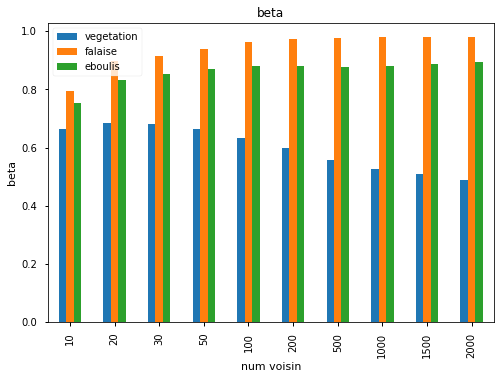

In [70]:
# plus beta est grand -> dimension 2D
beta.plot(kind="bar", title="beta")
plt.xlabel("num voisin")
plt.ylabel("beta")

Text(0.5, 0, 'num voisin')

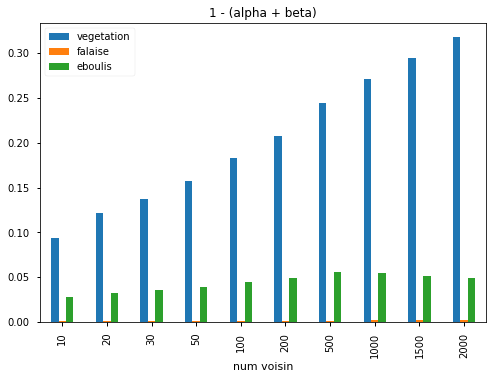

In [71]:
# ici, plus la valeur est grande plus la dimension 3D est prépondérante
(1 - (alpha + beta)).plot(kind="bar", title='1 - (alpha + beta)')
plt.xlabel("num voisin")

On veut pouvoir tracer l'évolution des ces trois valeurs en fonction de la distance (resp. nombre de voisins) pour chaque type d'éléments

In [72]:
triangle_vegetation = pd.DataFrame({"alpha": mean_features(vegetation_store, "alpha"),
                     "beta": mean_features(vegetation_store, "beta")})

triangle_vegetation["gamma"] = triangle_vegetation.eval("1 - alpha - beta")

In [73]:
triangle_vegetation

,alpha,beta,gamma
10,0.243248,0.663366,0.093386
20,0.192339,0.686297,0.121363
30,0.182236,0.680104,0.137660
50,0.178741,0.663827,0.157432
100,0.183587,0.633578,0.182835
200,0.195480,0.597182,0.207338
500,0.198764,0.557242,0.243995
1000,0.203904,0.524745,0.271351
1500,0.195272,0.509812,0.294917
2000,0.192241,0.490183,0.317576


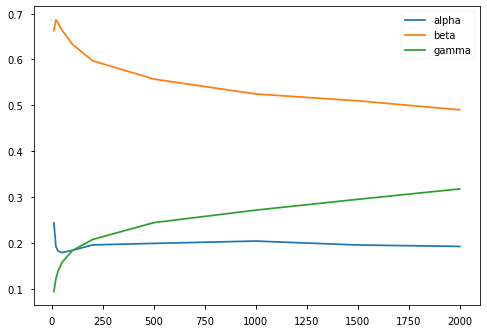

In [74]:
triangle_vegetation.plot()

In [75]:
triangle_falaise = pd.DataFrame({"alpha": mean_features(falaise_store, "alpha"),
                     "beta": mean_features(falaise_store, "beta")})

triangle_falaise["gamma"] = triangle_falaise.eval("1 - alpha - beta")

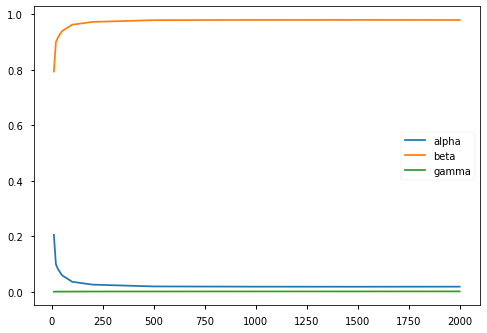

In [76]:
triangle_falaise.plot()

In [77]:
triangle_eboulis = pd.DataFrame({"alpha": mean_features(eboulis_store, "alpha"),
                     "beta": mean_features(eboulis_store, "beta")})

triangle_eboulis["gamma"] = triangle_eboulis.eval("1 - alpha - beta")

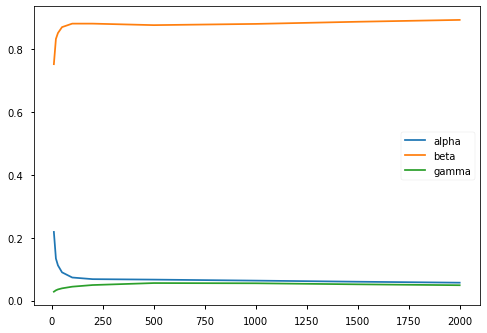

In [78]:
triangle_eboulis.plot()

#### Notion de verticalité

In [79]:
key = "verticality"
verticality = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                           "falaise": mean_features(falaise_store, key),
                           "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'verticality')

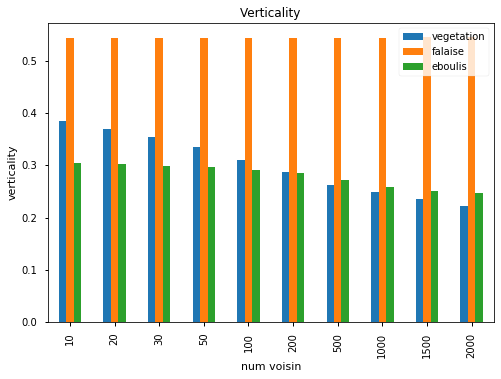

In [80]:
verticality.plot(kind="bar", title="Verticality")
plt.xlabel("num voisin")
plt.ylabel("verticality")

#### Linerarity, planarity & scattering

In [81]:
key = "linearity"
linearity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, '(e1 - e2)/e1 moy.')

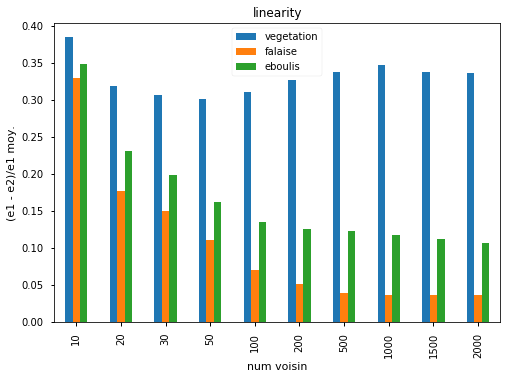

In [82]:
linearity.plot(kind="bar", title="linearity")
plt.xlabel("num voisin")
plt.ylabel("(e1 - e2)/e1 moy.")

In [83]:
key = "planarity"
planarity = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, '(e2 - e3)/e1 moy.')

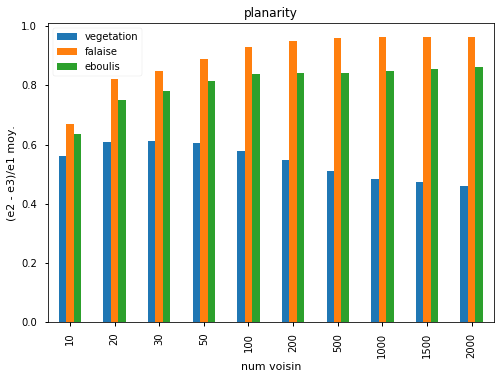

In [84]:
planarity.plot(kind="bar", title="planarity")
plt.xlabel("num voisin")
plt.ylabel("(e2 - e3)/e1 moy.")

In [85]:
key = "scattering"
scattering = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'e3 / e1 moy.')

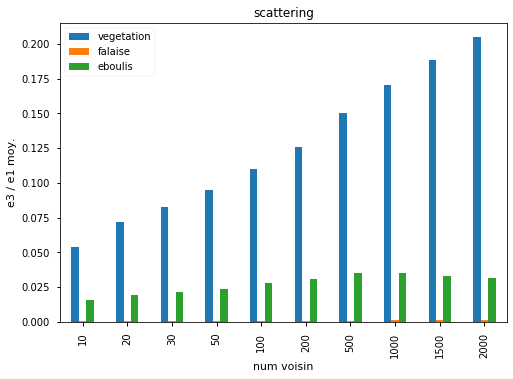

In [86]:
scattering.plot(kind="bar", title="scattering")
plt.xlabel("num voisin")
plt.ylabel("e3 / e1 moy.")

#### Curvature Change

In [110]:
key = "curvature_change"
curvature = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'e3 / (sum e_i) moy.')

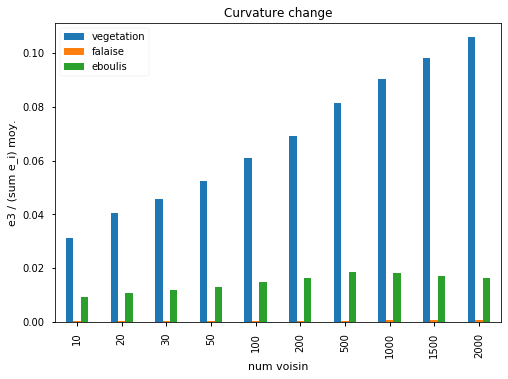

In [111]:
curvature.plot(kind="bar", title="Curvature change")
plt.xlabel("num voisin")
plt.ylabel("e3 / (sum e_i) moy.")

#### Omnivariance

In [87]:
key = "omnivariance"
omnivariance = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'sqrt(e1*e2*e3), 3) moy.')

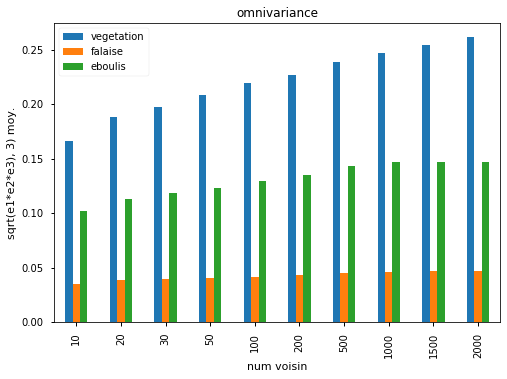

In [88]:
omnivariance.plot(kind="bar", title="omnivariance")
plt.xlabel("num voisin")
plt.ylabel("sqrt(e1*e2*e3), 3) moy.")

#### Anisotropy

In [89]:
key = "anisotropy"
anisotropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, '(e1 - e3)/e1 moy.')

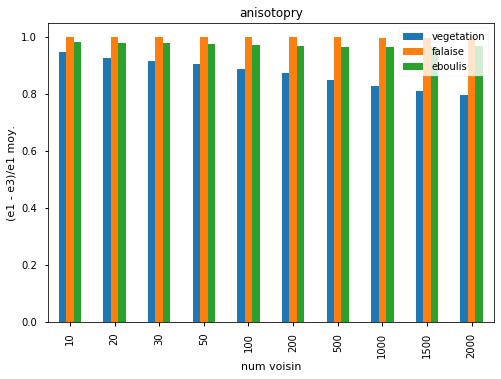

In [90]:
anisotropy.plot(kind="bar", title="anisotopry")
plt.xlabel("num voisin")
plt.ylabel("(e1 - e3)/e1 moy.")

#### Eigentropy

In [91]:
key = "eigenentropy"
eigentropy = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'minus sum e_i * ln e_i')

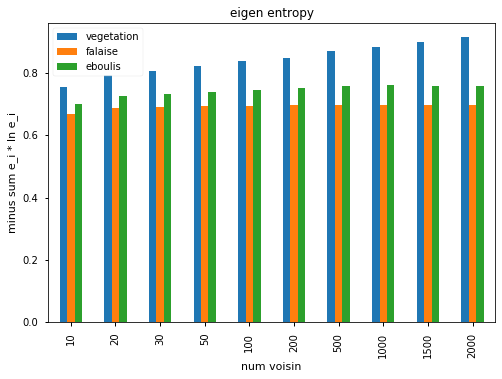

In [92]:
eigentropy.plot(kind="bar", title="eigen entropy")
plt.xlabel("num voisin")
plt.ylabel("minus sum e_i * ln e_i")

#### Eigenvalues Sum

In [93]:
key = "eigenvalue_sum"
eigensum = pd.DataFrame({"vegetation": mean_features(vegetation_store, key),
                          "falaise": mean_features(falaise_store, key),
                          "eboulis": mean_features(eboulis_store, key)})

Text(0, 0.5, 'sum lambda_i')

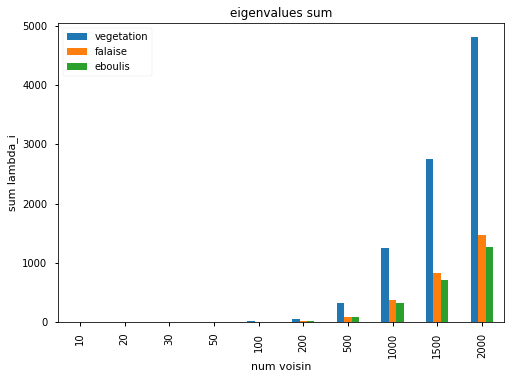

In [94]:
eigensum.plot(kind="bar", title="eigenvalues sum")
plt.xlabel("num voisin")
plt.ylabel("sum lambda_i")

### Corrélation de features pour un nombre de voisins donné

* On va concaténer selon axis=0 les données issues des différents échantillons (végétation, falaise, eboulis) pour un nombre de voisin donné
* On va calculer  une matrice de corrélation entre différente *features*

In [121]:
VOISIN_30 = "/num_0030"    # rayon sphère environ 20cm
VOISIN_1000 = "/num_1000"  # rayon sphère environ 1m

In [122]:
FEATURE_NAMES =  ['alpha',
 'beta',
 'radius',
 'z_range',
 'std_dev',
 'density',
 'verticality',
 'curvature_change',
 'linearity',
 'planarity',
 'scattering',
 'omnivariance',
 'anisotropy',
 'eigenentropy',
 'eigenvalue_sum',
 'radius_2D',
 'density_2D',
 'eigenvalue_sum_2D',
 'eigenvalue_ratio_2D']

In [123]:
def concat_features(voisin_num):
    return pd.concat([vegetation_store[voisin_num],
                      falaise_store[voisin_num],
                      eboulis_store[voisin_num]], axis=0, ignore_index=True)

In [124]:
features_30 = concat_features(VOISIN_30)

In [125]:
features_1000 = concat_features(VOISIN_1000)

In [126]:
features_1000.columns

Index(['x', 'y', 'z', 'alpha', 'beta', 'radius', 'z_range', 'std_dev',
       'density', 'verticality', 'curvature_change', 'linearity', 'planarity',
       'scattering', 'omnivariance', 'anisotropy', 'eigenentropy',
       'eigenvalue_sum', 'radius_2D', 'density_2D', 'eigenvalue_sum_2D',
       'eigenvalue_ratio_2D', 'bin_density', 'bin_z_range', 'bin_z_std', 'r',
       'g', 'b'],
      dtype='object')

In [127]:
rho_30 = features_30[FEATURE_NAMES].corr()

In [128]:
rho_1000 = features_1000[FEATURE_NAMES].corr()

On peut ré-ordonner le nom des labels

In [135]:
#b = rho_30.beta
#cols = b.sort_values(ascending=False).index
#cols

In [132]:
# ou on prend le même que l'autre notebook escale
cols = pd.Index(['beta', 'planarity', 'anisotropy', 'density_2D', 'density',
       'verticality', 'eigenvalue_ratio_2D', 'eigenvalue_sum_2D',
       'eigenvalue_sum', 'radius_2D', 'radius', 'std_dev', 'z_range', 'alpha',
       'linearity', 'eigenentropy', 'omnivariance', 'scattering',
       'curvature_change'])

Matrice de corrélation des *features* pour un **voisinnage de 30 points**

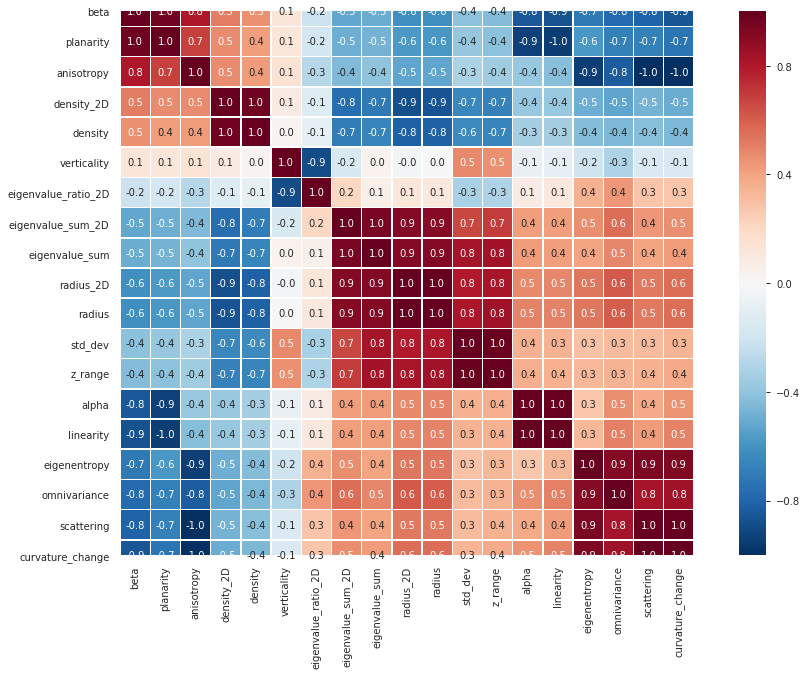

In [133]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_30.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)

Matrice de corrélation des *features* pour un **voisinnage de 1000 points**

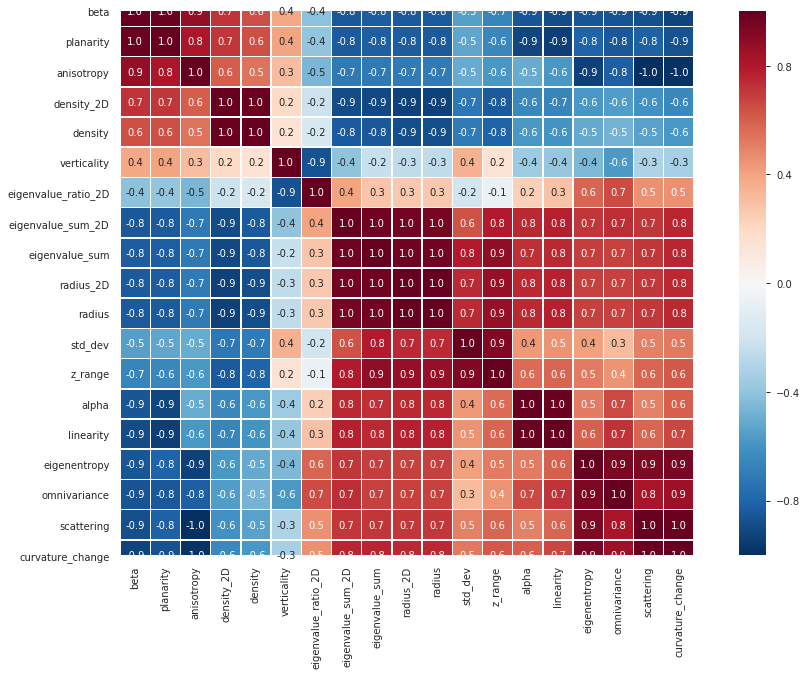

In [134]:
with sns.axes_style("white", {'xtick.major.size': 12.0}):
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(rho_1000.loc[cols, cols], square=True, cmap='RdBu_r',
                center=0., linewidths=.5, annot=True, fmt=".1f", ax=ax)